# Proyecto 1A: Colorizando una colección de fotos


## Víctor Samuel Pérez Díaz
## Sergio Nicolás Duque Báez

In [1]:
import numpy as np
import skimage as sk
from skimage import transform
from skimage import filters
import skimage.io as skio
import matplotlib.pyplot as plt
import time

import os

In [2]:
# Puntuacion de coincidencia
def align_score(im1, im2, metric='ssd'):
    
    # Suma de diferencias cuadradas
    if metric == 'ssd':
        return np.sum(np.sum((im1-im2)**2))
    
    # Correlacion cruzada normalizada
    if metric == 'ncc':
        im1_norm = im1.flatten()/np.linalg.norm(im1.flatten())
        im2_norm = im2.flatten()/np.linalg.norm(im2.flatten())
        return np.dot(im1_norm,im2_norm)

# Extraemos el borde y retornamos la coordenada
# Se realiza para el caso de filas o columnas
def border(edges, c, default, row_or_col):
    
    # Seleccionamos unos thresholds para acotar la búsqueda
    thresh = len(c)/100
    mov = int(c.shape[1]/15)
    
    c_border = default
    
    # Buscamos el borde según el threshold
    # También según si es columna o no
    if row_or_col:
        for i in range(0, mov):
            if default == 0:
                val = np.sum(c[mov-i])
                
                if val >= thresh:
                    c_border = mov-i
                    break
            else:
                val = np.sum(c[default-1-(mov-i)])
                
                if val >= thresh:
                    c_border = default-1-(mov-i) 
                    break
    else:
        for i in range(0, mov):
            if default == 0:
                val = np.sum(c[:,mov-i])
                
                if val >= thresh:
                    c_border = mov-i
                    break
            else:
                val = np.sum(c[:,default-1-(mov-i)])
                
                if val >= thresh:
                    c_border = default-1-(mov-i)
                    break        
                    
    return c_border

# Helper para la función principal de recorte
# Se calcula el filtro de sobel, que nos ayuda a hacer edge detection
def sobel_crop_helper(c):
    edges = filters.sobel(c)
    
    # Calculamos los bordes en cada lado
    top = border(edges, c, 0, row_or_col = True) 
    bot = border(edges, c, edges.shape[0], row_or_col = True) 
    lef = border(edges, c, 0, row_or_col = False) 
    rig = border(edges, c, edges.shape[1], row_or_col = False) 
    
    return (top, bot, lef, rig)

# Función principal de recorte de bordes a través de filtración sobel (edge detection)
# Hacemos recorte en cada componente, seleccionamos la mejor imágen, y recortamos todas con esas dimensiones
def sobel_crop(r, g, b):
    eval_crop = lambda x:(x[1]-x[0])*(x[3]-x[2])
    crop = lambda im,lim:im[lim[0]:lim[1], lim[2]:lim[3]] 
    cropmin = min([sobel_crop_helper(r), sobel_crop_helper(g), sobel_crop_helper(b)], key=eval_crop)
    
    
    R = crop(r, cropmin)
    G = crop(g, cropmin)
    B = crop(b, cropmin)
    
    return R,G,B
          
# Busqueda exhaustiva
# Para SSD minimizamos, mientras que para NCC maximizamos
# Movemos la imagen en un espacio de -15 a 15 y buscamos el puntaje optimo
def exhaustive(im1, im2, metric, interval):
    attempts = []
    if type(interval) == tuple:
        for i in range(interval[0], interval[2]):
            for j in range(interval[1], interval[3]):
                im1_mov = np.roll(im1, i, 1)
                im1_mov = np.roll(im1_mov, j, 0)

                score = align_score(im1_mov, im2, metric)
                attempts.append([[i,j], score])
        
    else:
        for i in range(-interval, interval):
            for j in range(-interval, interval):
                im1_mov = np.roll(im1, i, 1)
                im1_mov = np.roll(im1_mov, j, 0)

                score = align_score(im1_mov, im2, metric)
                attempts.append([[i,j], score])


    # Retornamos puntaje óptimo para la métrica determinada
    if metric == 'ssd':
        best_score = min(attempts, key=lambda attempt:attempt[1])

    elif metric == 'ncc':
        best_score = max(attempts, key=lambda attempt:attempt[1])
    
    
    return best_score[0]

# Paso recursivo del método piramidal
# Vamos subiendo en el tamaño de la imagen en cada paso recursivo
def pyramid_helper(im1, im2, metric, interval, scale, best_disp):
    
    # Caso base
    if scale > 1:
        return best_disp
    
    # Reescalamos con la escala del paso recursivo
    im1_res = sk.transform.rescale(im1, scale)
    im2_res = sk.transform.rescale(im2, scale)
    interval = ((best_disp[0]-1)*2, (best_disp[1]-1)*2, (best_disp[0]+1)*2, (best_disp[1]+1)*2)
    best_disp = exhaustive(im1_res, im2_res, metric, interval)
    
    # Duplicamos la escala (aumentamos el tamaño de la imagen)
    new_scale = 2*scale
    return pyramid_helper(im1, im2, metric, interval, new_scale, best_disp)

# Inicializamos método piramidal 
def pyramid(im1, im2, metric, interval):
    scale = 1/32
    im1_res = sk.transform.rescale(im1, scale)
    im2_res = sk.transform.rescale(im2, scale)
    
    best_disp = exhaustive(im1_res, im2_res, metric, 2)
    
    new_scale = 2*scale
    return pyramid_helper(im1, im2, metric, interval, new_scale, best_disp)
    

# Alineamos las imagenes dependiendo de su tamaño/resolucion
def align(im1, im2, res='low', metric='ssd', interval=15):

    # Busqueda piramidal
    if res == 'high':
        return pyramid(im1, im2, metric, interval)

    # Busqueda exhaustiva
    if res == 'low':
        return exhaustive(im1, im2, metric, interval)

# Función principal
# imname: nombre de la imágen
# res: string, resolución ('low', 'high')
# metric: string, métrica a usar ('ssd', 'ncc')
# interval: tupla o entero, intervalo de la ventana para el alineamiento
# aligning: boolean, alinear o no alinear
# save: boolean, guardar o no guardar
# crop: boolean, recortar bordes feos o no
def colorizar(imname, res, metric, interval=15, aligning=True, save=True, crop=True):
    tic = time.time()
    # read in the image
    im = skio.imread(imname)

    # convert to double (might want to do this later on to save memory)    
    im = sk.img_as_float(im)

    # compute the height of each part (just 1/3 of total)
    height = np.floor(im.shape[0] / 3.0).astype(np.int)

    # separate color channels
    b = im[:height]
    g = im[height: 2*height]
    r = im[2*height: 3*height]
    
    if crop:
        
        r,g,b = sobel_crop(r, g, b)
        

    # align the images
    if aligning:
        ag = align(g, b, res, metric, interval)
        g = np.roll(np.roll(g, ag[1], 0), ag[0], 1)
        ar = align(r, g, res, metric, interval)
        r = np.roll(np.roll(r, ar[1], 0), ar[0], 1)

        if crop:
            r,g,b = sobel_crop(r, g, b)
            
        # create a color image
        im_out = np.dstack([r, g, b])
        print("Desplazamiento:", ag, ar)
    else:
        im_out = np.dstack([r, g, b])
    
    # Tiempo
    toc = time.time()
    print("Tiempo: " + str(toc - tic))
    
    # display the image
    plt.figure(figsize=(20,10))
    skio.imshow(im_out)
    skio.show()
    
    # Guardar
    if save:
        fname = os.path.basename(imname).split(".")[0] + '.jpg'
        skio.imsave(fname, im_out)
    
    return im_out

In [3]:
# main

# name of the input file
imname = 'img/cathedral.jpg'
colorizar(imname, 'low', 'ssd', aligning=True, save=True, crop=False);

Desplazamiento: [-1, 1] [-1, 8]
Tiempo: 2.9389901161193848


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [4]:
colorizar(imname, 'low', 'ssd', aligning=True, save=True);

Desplazamiento: [2, 5] [3, 12]
Tiempo: 0.6630024909973145


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Desplazamiento: [2, -3] [3, 3]
Tiempo: 0.5969815254211426


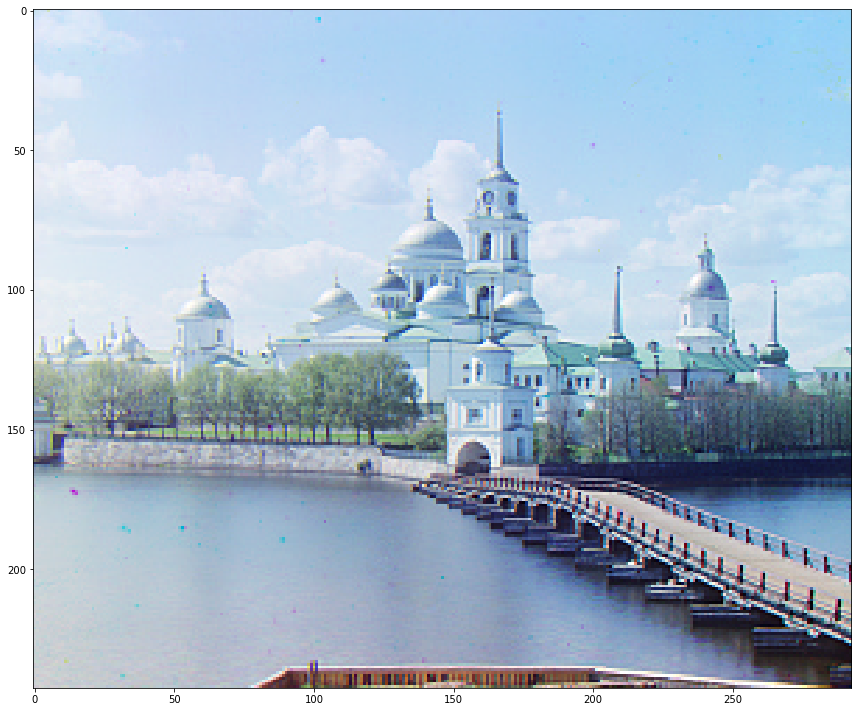

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [5]:
imname = 'img/monastery.jpg'
colorizar(imname, 'low', 'ssd', aligning=True, save=True);

Desplazamiento: [2, 3] [3, 7]
Tiempo: 2.4280006885528564


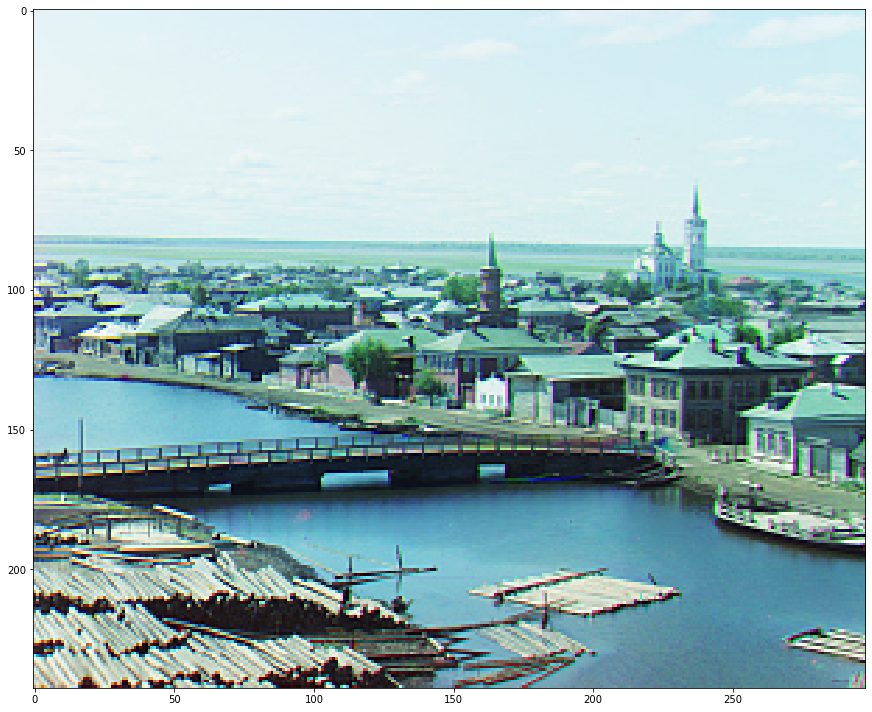

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [6]:
imname = 'img/tobolsk.jpg'
colorizar(imname, 'low', 'ssd', aligning=True, save=True);

Desplazamiento: [9, 47] [9, 63]
Tiempo: 20.322002172470093


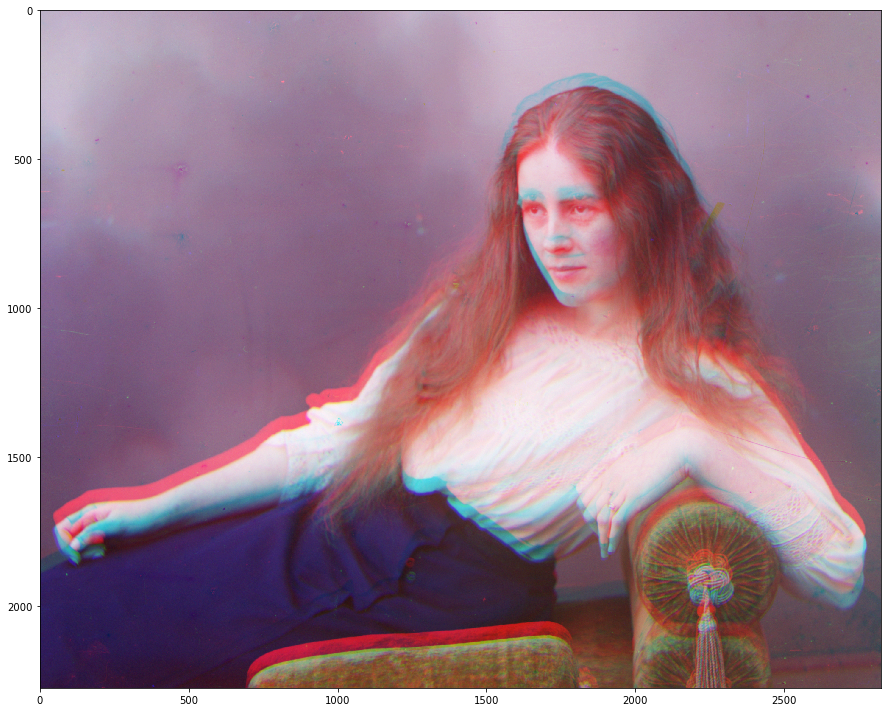

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [7]:
imname = 'img/lady.tif'
colorizar(imname, 'high', 'ssd', aligning=True, save=True);

Desplazamiento: [24, 49] [40, 63]
Tiempo: 21.116976976394653


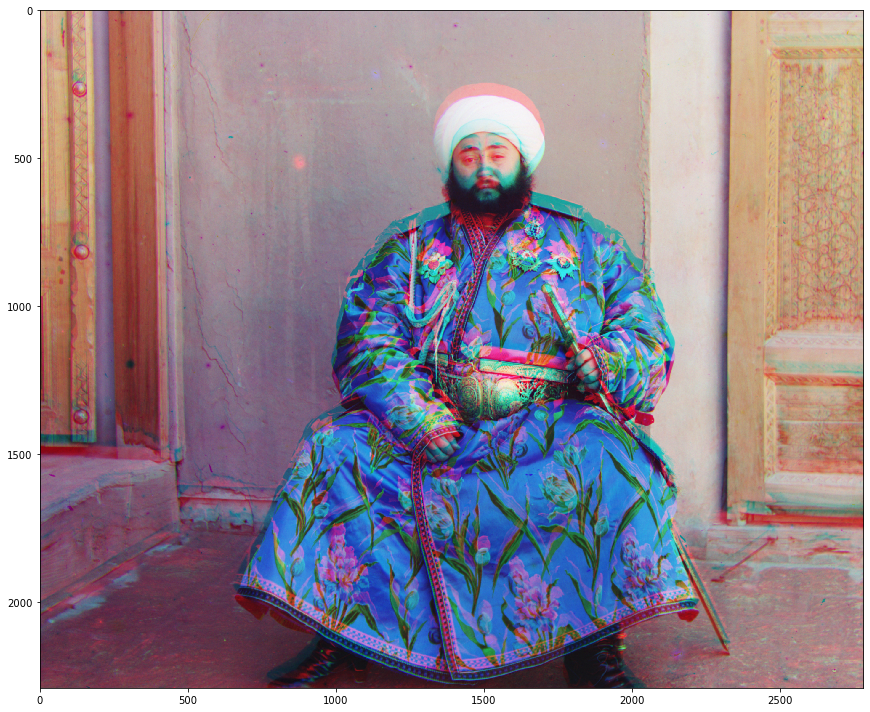

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [8]:
imname = 'img/emir.tif'
colorizar(imname, 'high', 'ssd', aligning=True, save=True);